# 0.0 Importando bibliotecas

In [1]:
import pandas as pd
import plotly as plt
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
from matplotlib             import ticker
from sklearn.preprocessing  import RobustScaler
from boruta                 import BorutaPy
from matplotlib             import pyplot as plt
from IPython.core.display   import HTML
from sklearn                import ensemble as en
from imblearn               import combine as c
from sklearn.dummy          import DummyClassifier
from sklearn                import linear_model as lm
from xgboost                import XGBClassifier
from sklearn                import model_selection as ms
from sklearn                import neighbors as nh
from scikitplot             import metrics      as mt
from sklearn.metrics        import confusion_matrix
from sklearn                import metrics as m

# 1.0 Funções

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use ('bmh')
    plt.rcParams['figure.figsize'] = [25,12] #set graph size
    plt.rcParams['font.size'] = 24
    display(HTML ('<style>.container { width:90% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option ('display.expand_frame_repr', False)
    sns.set()
    
jupyter_settings()

# 2.0 Carregando os dados de treino

In [3]:
data_raw = pd.read_csv('treino.csv')

In [4]:
data_raw.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# 3.0 Descrição dos Dados

In [5]:
df1 = data_raw.copy()

**idade:** A idade do cliente..

**numero_de_dependentes:** O número de pessoas dependentes do cliente.

**salario_mensal:** Salário mensal do cliente.

**numero_emprestimos_imobiliarios:** Quantidade de empréstimos imobiliários que o cliente possui em aberto.

**numero_vezes_passou_90_dias:** Número de vezes que o tomador passou mais de 90 dias em atraso.

**util_linhas_inseguras:** Quanto que o cliente está usando, relativamente ao limite dele, de linhas de crédito que não são seguradas por qualquer bem do tomador e.g: imoveis, carros etc.

**vezes_passou_de_30_59_dias:** Número de vezes que o cliente atrasou, entre 30 e 59 dias, o pagamento de um empréstimo.

**razao_debito:** Razão entre as dívidas e o patrimônio do tomador. razão débito = Dividas/Patrimônio

**numero_linhas_crdto_aberto:** Número de empréstimos em aberto pelo cliente.

**numero_de_vezes_que_passou_60_89_dias:** Número de vezes que o cliente atrasou, entre 60 e 89 dias, o pagamento de um empréstimo.


In [6]:
nrows = df1.shape[0]
ncolumns = df1.shape[1]

print(f'O número de linhas é {nrows}')
print(f'O número de colunas é {ncolumns}')

O número de linhas é 110000
O número de colunas é 11


### 3.1 Verificar NAs

In [7]:
df1.isna().sum()

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

In [8]:
#numero de dependentes: considerou-se que quando sem preenchimento, cliente não possui dependentes.
df1['numero_de_dependentes'] = df1['numero_de_dependentes'].apply (lambda x: 0 if math.isnan(x) else x)

#salario_mensal: optou-se por dropar linhas sem informação de salário neste primeiro ciclo
df1 = df1.dropna()

### 3.2 Tipos de Dados

In [9]:
df1.dtypes

inadimplente                               int64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
dtype: object

In [10]:
#alterando 'numero_de_dependetes' para inteiro
df1['numero_de_dependentes'] = df1['numero_de_dependentes'].astype(int)

### 3.3 Verificar Balanceamento dos Dados 

In [11]:
df1['inadimplente'].value_counts(normalize = True)

0    0.931049
1    0.068951
Name: inadimplente, dtype: float64

### 3.4 Estatísticas

In [12]:
#central
df1_mean = pd.DataFrame(df1.apply(np.mean))
df1_median = pd.DataFrame(df1.apply(np.median))

#dispersions
df1_std = pd.DataFrame(df1.apply(np.std))
df1_max = pd.DataFrame(df1.apply(max))
df1_min = pd.DataFrame(df1.apply(min))
df1_range = pd.DataFrame(df1.apply(lambda x: x.max() - x.min()))
df1_skew = pd.DataFrame(df1.apply(lambda x: x.skew()))
df1_kurtosis = pd.DataFrame(df1.apply(lambda x: x.kurtosis()))

statistics = pd.concat([df1_min, df1_max, df1_range, df1_mean, df1_median, df1_std, df1_skew, df1_kurtosis], axis =1).reset_index()
statistics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard deviation', 'skewness', 'kurtosis']
statistics

,attributes,min,max,range,mean,median,standard deviation,skewness,kurtosis
0,inadimplente,0.0,1.0,1.0,0.068951,0.000000,0.253370,3.402583,9.577791
1,util_linhas_inseguras,0.0,50708.0,50708.0,5.855376,0.178883,260.697959,114.138591,18622.858549
2,idade,0.0,103.0,103.0,51.248320,51.000000,14.413494,0.225654,-0.475708
3,vezes_passou_de_30_59_dias,0.0,98.0,98.0,0.387491,0.000000,3.596237,26.050246,703.028768
4,razao_debito,0.0,61106.5,61106.5,26.827167,0.296660,389.680036,61.819687,7613.139273
5,salario_mensal,0.0,3008750.0,3008750.0,6637.411063,5400.000000,13383.875102,140.701543,29432.520949
6,numero_linhas_crdto_aberto,0.0,58.0,58.0,8.755352,8.000000,5.165914,1.205384,3.154251
7,numero_vezes_passou_90_dias,0.0,98.0,98.0,0.218593,0.000000,3.563066,26.915575,734.779313
8,numero_emprestimos_imobiliarios,0.0,54.0,54.0,1.055884,1.000000,1.156476,3.976981,81.274148
9,numero_de_vezes_que_passou_60_89_dias,0.0,98.0,98.0,0.194125,0.000000,3.547127,27.284963,748.845453


### 3.4 Filtrar linhas

In [13]:
df1 = df1.loc[df1['salario_mensal'] < 3008750] #retirando salário de 3.008.750
df1 = df1.loc[df1['idade'] >= 18] #retirando idade 0 (1 ocorrência)

# 4.0 Análise Exploratória de Dados

### 4.1 Análise Univariada

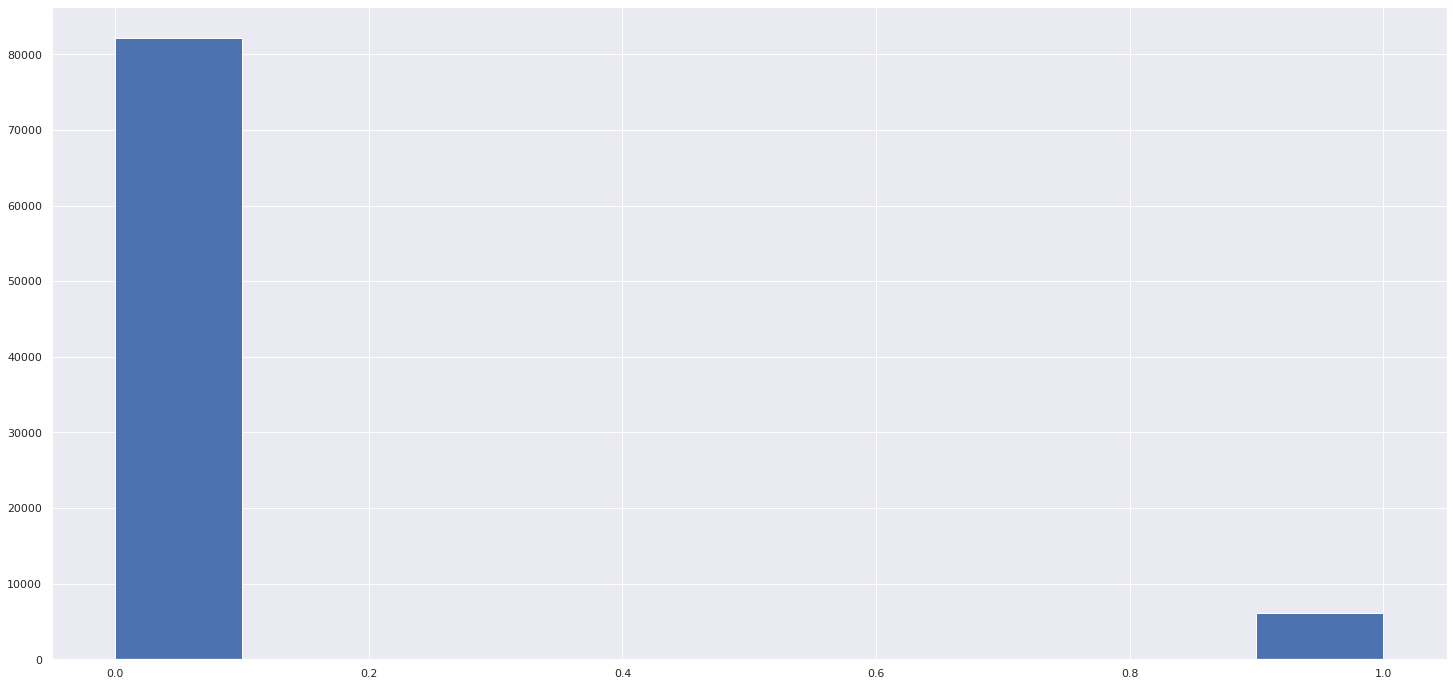

In [14]:
#analise univariada
df2 = df1.copy()
df2['inadimplente'].hist();

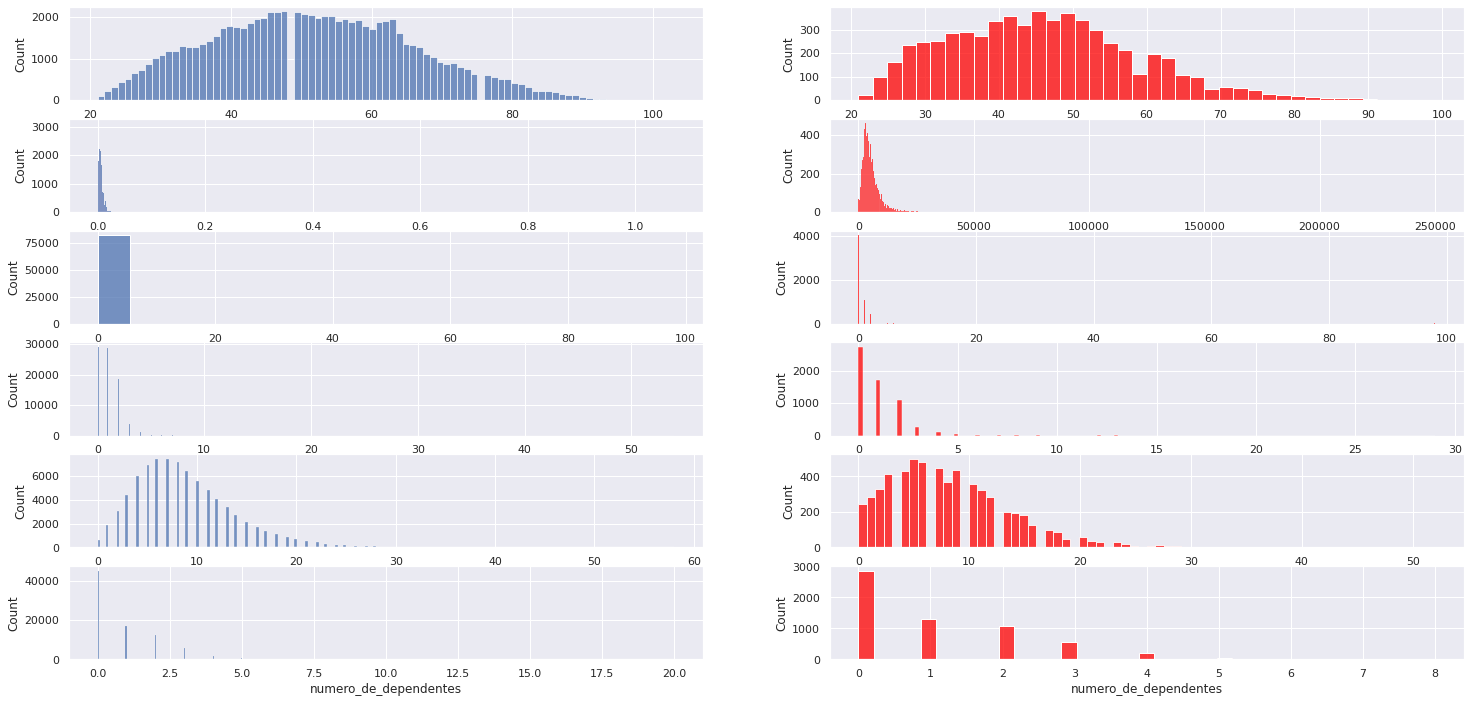

In [15]:
aux0 = df2.loc[df2['inadimplente'] == 0]
aux1 = df2.loc[df2['inadimplente'] == 1]

plt.subplot(6,2,1)
sns.histplot(data=aux0, x="idade");
plt.subplot(6,2,2)
sns.histplot(data=aux1, x="idade", color = 'red');

plt.subplot(6,2,3)
sns.histplot(data=aux0, x="salario_mensal");
plt.subplot(6,2,4)
sns.histplot(data=aux1, x="salario_mensal", color = 'red');

plt.subplot(6,2,5)
sns.histplot(data=aux0, x="numero_vezes_passou_90_dias");
plt.subplot(6,2,6)
sns.histplot(data=aux1, x="numero_vezes_passou_90_dias", color = 'red');

plt.subplot(6,2,7)
sns.histplot(data=aux0, x="numero_emprestimos_imobiliarios");
plt.subplot(6,2,8)
sns.histplot(data=aux1, x="numero_emprestimos_imobiliarios", color = 'red');

plt.subplot(6,2,9)
sns.histplot(data=aux0, x="numero_linhas_crdto_aberto");
plt.subplot(6,2,10)
sns.histplot(data=aux1, x="numero_linhas_crdto_aberto", color = 'red');

plt.subplot(6,2,11)
sns.histplot(data=aux0, x="numero_de_dependentes");
plt.subplot(6,2,12)
sns.histplot(data=aux1, x="numero_de_dependentes", color = 'red');

### 4.2 Hipóteses

### Hipótese 1: Clientes com salários mais altos são menos inadimplentes do que aqueles com salários mais baixos:

##### Verdadeiro: À medida que o o salário cresce, há menos ocorrência de inadimplência

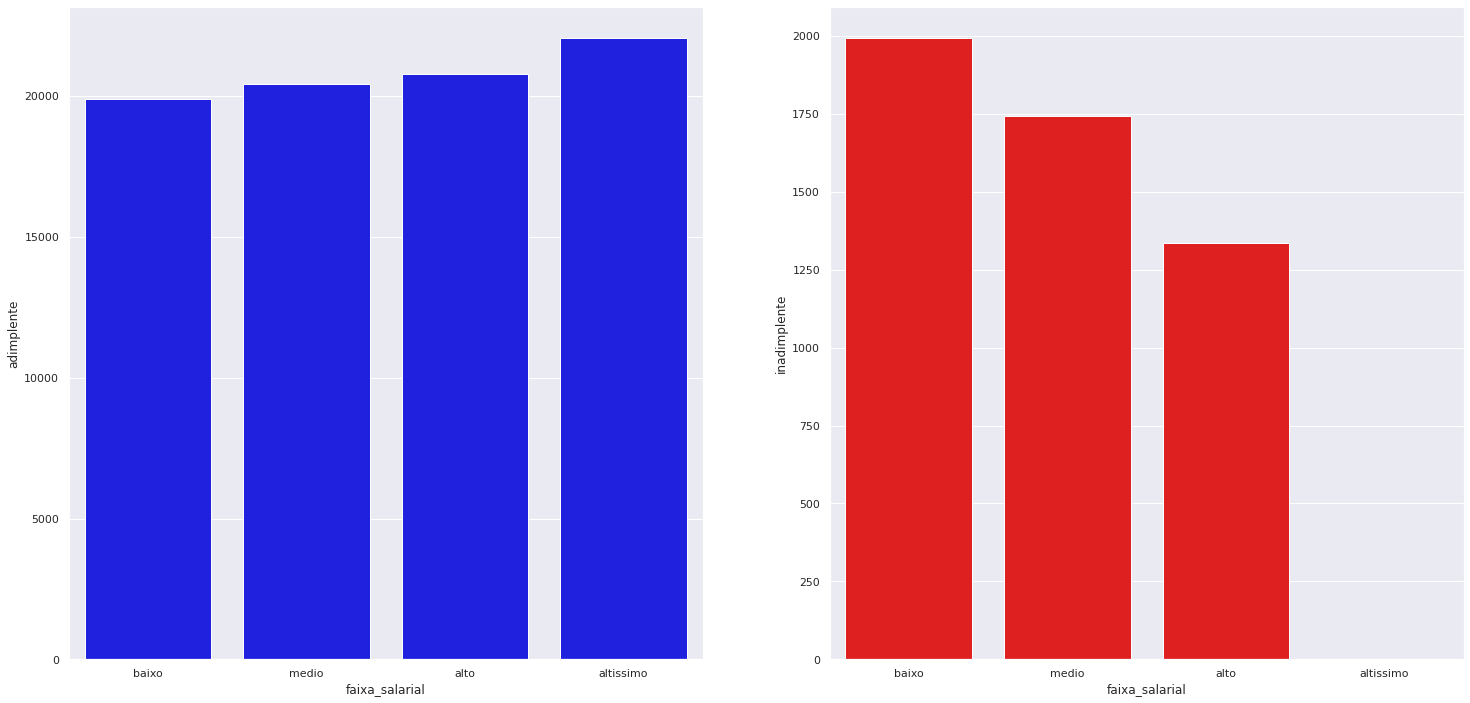

In [35]:
quartis = df2.salario_mensal.quantile([0.25,0.5,0.75])

df2['faixa_salarios'] = df2['salario_mensal'].apply(lambda x: 'baixo salario' if x < 3400 else
                                                                        'medio salario' if x < 5400 else
                                                                        'alto salario' if x < 8225 else
                                                                        'altissimo salario')


baixo_sal_total_pessoas = df2.loc[df2['faixa_salarios'] == 'baixo salario', 'inadimplente'].count()
baixo_sal_inadimplente  = df2.loc[df2['faixa_salarios'] == 'baixo salario', 'inadimplente'].sum()
baixo_sal_n_inadimplente = baixo_sal_total_pessoas - baixo_sal_inadimplente

medio_sal_total_pessoas = df2.loc[df2['faixa_salarios'] == 'medio salario', 'inadimplente'].count()
medio_sal_inadimplente  = df2.loc[df2['faixa_salarios'] == 'medio salario', 'inadimplente'].sum()
medio_sal_n_inadimplente = medio_sal_total_pessoas - medio_sal_inadimplente

alto_salario_total_pessoas = df2.loc[df2['faixa_salarios'] == 'alto salario', 'inadimplente'].count()
alto_salario_inadimplente  = df2.loc[df2['faixa_salarios'] == 'alto salario', 'inadimplente'].sum()
alto_salario_n_inadimplente = alto_salario_total_pessoas - alto_salario_inadimplente

altissimo_salario_total_pessoas = df2.loc[df2['faixa_salarios'] == 'altissimo salario', 'inadimplente'].count()
altissimo_salario_inadimplente  = df2.loc[df2['faixa_salarios'] == 'altissimo salário', 'inadimplente'].sum()
altissimo_salario_n_inadimplente = altissimo_salario_total_pessoas - altissimo_salario_inadimplente

dict_  = {'baixo': [baixo_sal_inadimplente, baixo_sal_n_inadimplente], 'medio': [medio_sal_inadimplente, medio_sal_n_inadimplente], 'alto': [alto_salario_inadimplente, alto_salario_n_inadimplente], 'altissimo': [altissimo_salario_inadimplente, altissimo_salario_n_inadimplente ]}
df_aux = pd.DataFrame.from_dict(dict_).T.reset_index()
df_aux.columns = ['faixa_salarial', 'inadimplente', 'adimplente']

plt.subplot(1,2,1)
ax = sns.barplot(x='faixa_salarial', y='adimplente', data=df_aux, color = 'blue')


plt.subplot(1,2,2)
ax = sns.barplot(x="faixa_salarial", y="inadimplente", data=df_aux, color = 'red')

ax;

### Hipótese 2: Clientes mais jovens são mais inadimplentes do que cliente mais velhos

#### Verdadeiro: Conforme a idade aumenta, há menos ocorrência de inadimplência

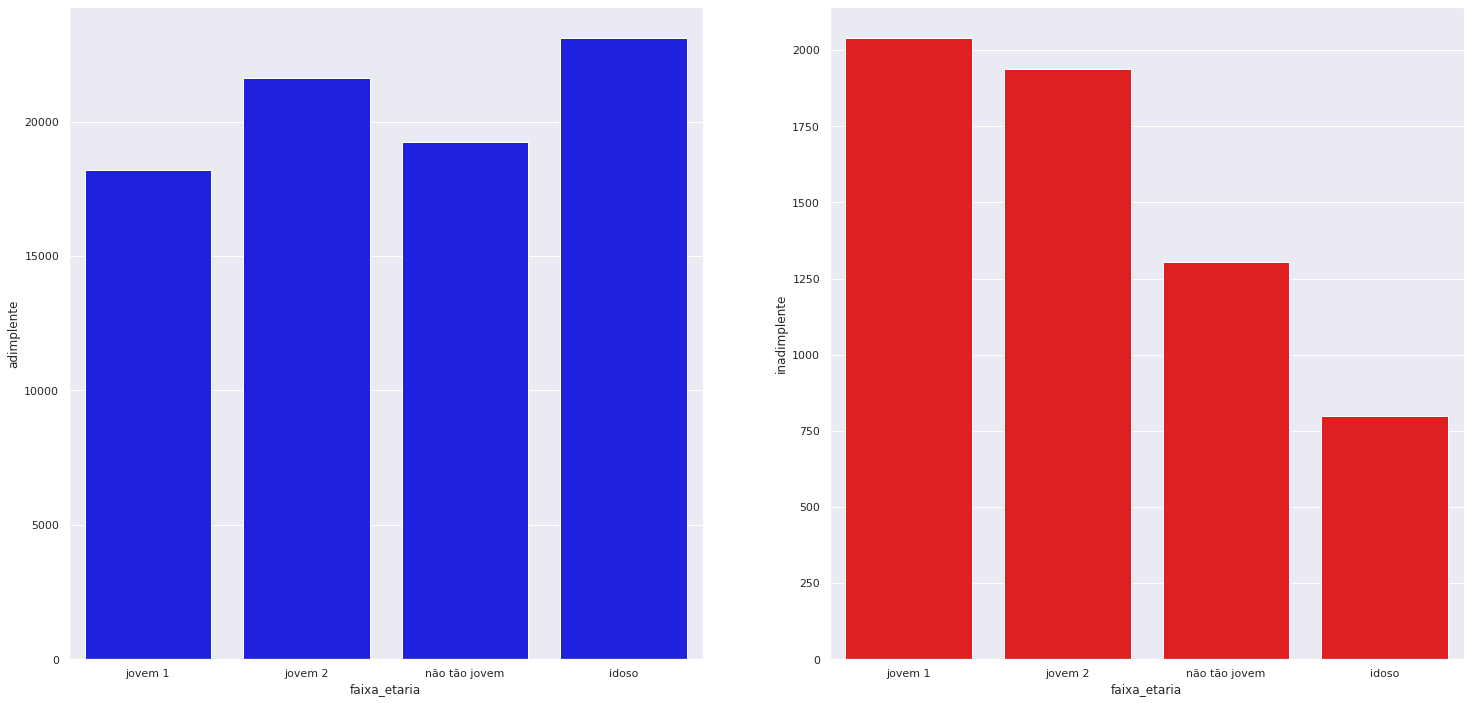

In [41]:
#quartis = df2.idade.quantile([0.25,0.5,0.75])
#quartis
df2['faixa_etaria'] = df2['idade'].apply(lambda x: 'jovem 1' if x < 40 else
                                                   'jovem 2' if x < 51 else
                                                   'não tão jovem' if x < 61 else
                                                   'idoso')



jovem_1_total_pessoas = df2.loc[df2['faixa_etaria'] == 'jovem 1', 'inadimplente'].count()
jovem_1_inadimplente  = df2.loc[df2['faixa_etaria'] == 'jovem 1', 'inadimplente'].sum()
jovem_1_n_inadimplente = jovem_1_total_pessoas - jovem_1_inadimplente

jovem_2_total_pessoas = df2.loc[df2['faixa_etaria'] == 'jovem 2', 'inadimplente'].count()
jovem_2_inadimplente  = df2.loc[df2['faixa_etaria'] == 'jovem 2', 'inadimplente'].sum()
jovem_2_n_inadimplente = jovem_2_total_pessoas - jovem_2_inadimplente

não_tão_jovem_total_pessoas = df2.loc[df2['faixa_etaria'] == 'não tão jovem', 'inadimplente'].count()
não_tão_jovem_inadimplente  = df2.loc[df2['faixa_etaria'] == 'não tão jovem', 'inadimplente'].sum()
não_tão_jovem_n_inadimplente = não_tão_jovem_total_pessoas - não_tão_jovem_inadimplente

idoso_total_pessoas = df2.loc[df2['faixa_etaria'] == 'idoso', 'inadimplente'].count()
idoso_inadimplente  = df2.loc[df2['faixa_etaria'] == 'idoso', 'inadimplente'].sum()
idoso_n_inadimplente = idoso_total_pessoas - idoso_inadimplente

dict_  = {'jovem 1': [jovem_1_inadimplente, jovem_1_n_inadimplente], 'jovem 2': [jovem_2_inadimplente, jovem_2_n_inadimplente], 'não tão jovem': [não_tão_jovem_inadimplente, não_tão_jovem_n_inadimplente], 'idoso': [idoso_inadimplente, idoso_n_inadimplente ]}
df_aux = pd.DataFrame.from_dict(dict_).T.reset_index()
df_aux.columns = ['faixa_etaria', 'inadimplente', 'adimplente']
df_aux

plt.subplot(1,2,1)
ax = sns.barplot(x='faixa_etaria', y='adimplente', data=df_aux, color = 'blue');

plt.subplot(1,2,2)
ax = sns.barplot(x="faixa_etaria", y="inadimplente", data=df_aux, color = 'red');


ax;

### Hipótese 3: Clientes com mais dependentes são mais inadimplentes

#### Falso: Há pouca relação entre o número de dependentes e a inadimplência

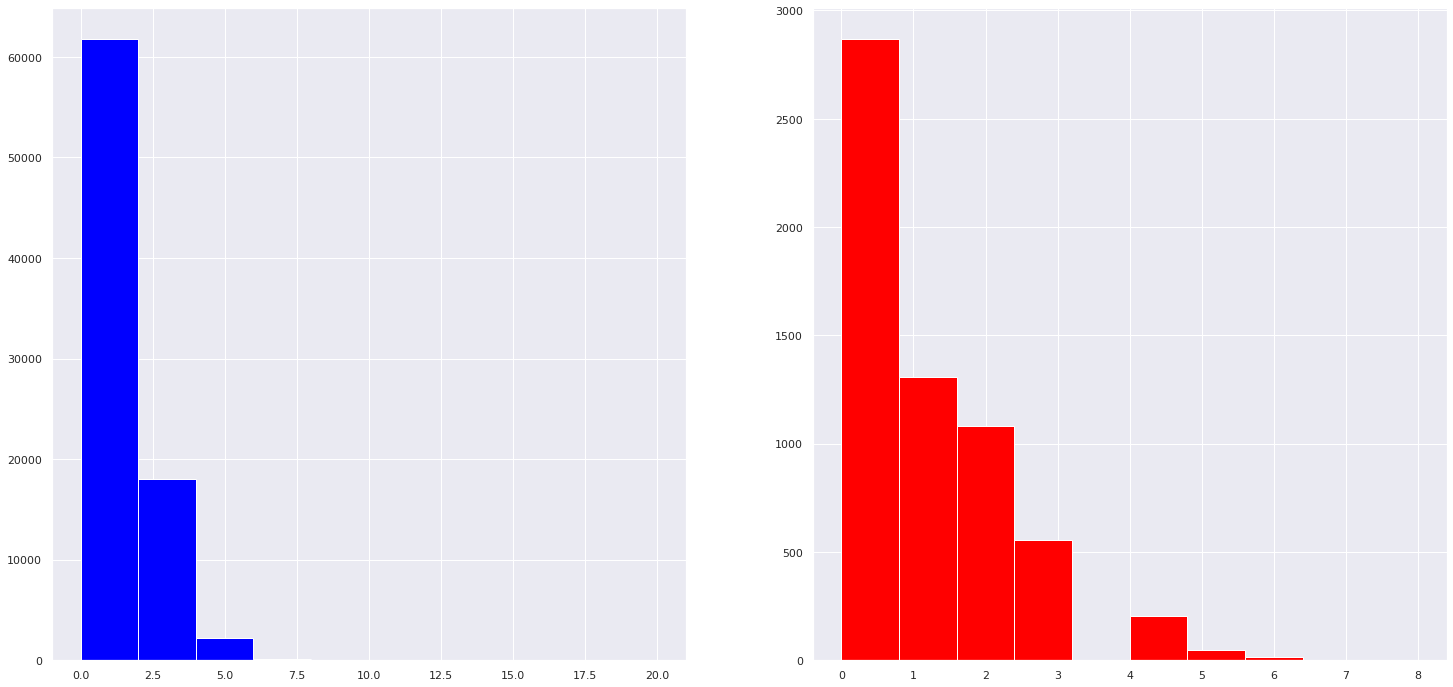

In [43]:
df2['numero_de_dependentes'].unique()

aux0 = df2.loc[df2['inadimplente'] == 0]
aux1 = df2.loc[df2['inadimplente'] == 1]

plt.subplot(1,2,1)
aux0['numero_de_dependentes'].hist(color = 'blue');


plt.subplot(1,2,2)
aux1['numero_de_dependentes'].hist(color = 'red');


### 4.3 Análise Multivariada

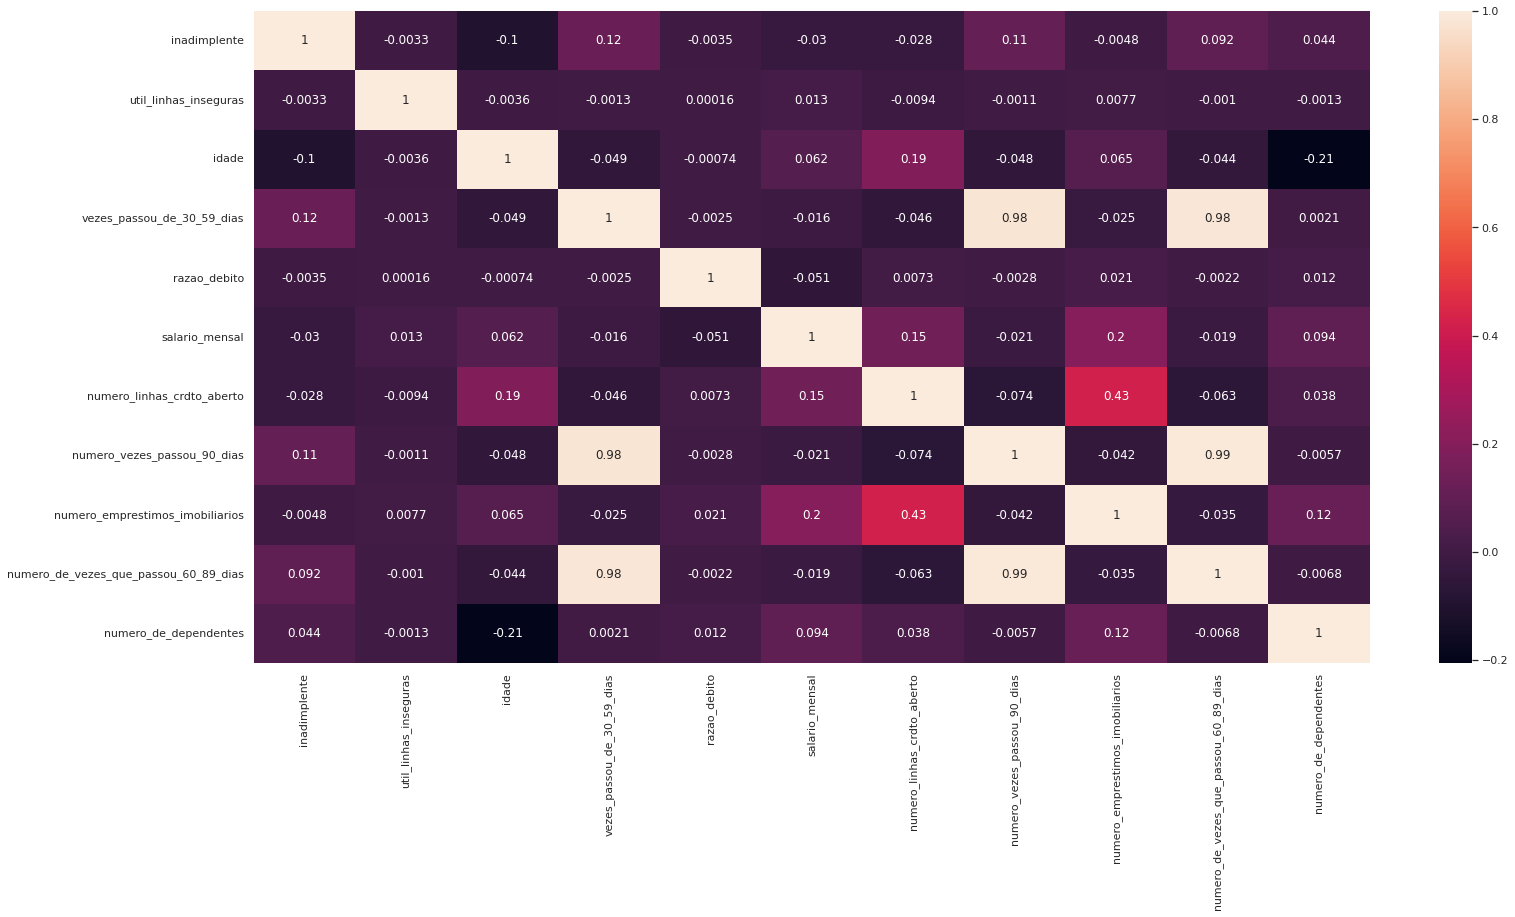

In [44]:
correlation = df2.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 5.0 Balanceamento de Dados

In [45]:
df3 = df2.drop(columns = ['inadimplente', 'faixa_salarios', 'faixa_etaria'])

### 5.1 SMOTE + TOMEKLINK

In [46]:
#define sampler
smt = c.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

#apply sampler
X_smt, y_smt = smt.fit_resample (df3, df2['inadimplente'])

In [47]:
df4 = X_smt
df4['inadimplente'] = y_smt

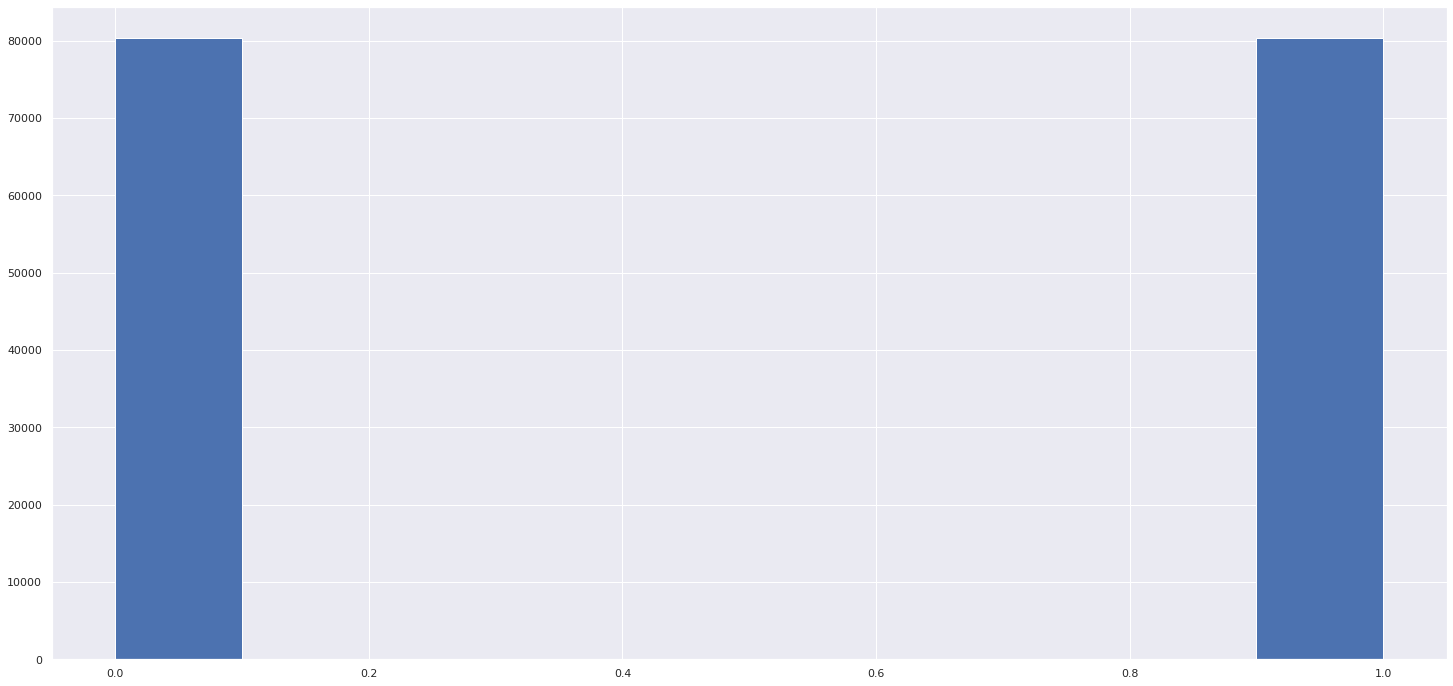

In [48]:
df4['inadimplente'].hist();

# 6.0 Preparação de Dados

### 6.1 Dividir dataframe em dados de treino e validação

In [49]:
df5 = df4.copy()
X = df4.drop(columns = 'inadimplente', axis=1)
y = df4['inadimplente'].copy()

In [50]:
x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)
df5 = pd.concat ([x_train, y_train], axis =1 ) #df5 possui apenas variaveis do treino

### 6.2 Reescala

In [26]:
#reescalando features com valores muito altos

rs = RobustScaler()

#util_linhas_inseguras
x_train['util_linhas_inseguras'] = rs.fit_transform(x_train[['util_linhas_inseguras']].values)
x_train['util_linhas_inseguras'] = rs.fit_transform(x_train[['util_linhas_inseguras']].values)

#razao_debito
x_train['razao_debito'] = rs.fit_transform(x_train[['razao_debito']].values)
x_val['razao_debito'] = rs.fit_transform(x_val[['razao_debito']].values)

#salario_mensal
x_train['salario_mensal'] = rs.fit_transform(x_train[['salario_mensal']].values)
x_val['salario_mensal'] = rs.fit_transform(x_val[['salario_mensal']].values)

# 7.0. Seleção de Features

### 7.1 Feature Importance

In [27]:
#modelo
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

#preparando dados
x_train_n = df5.drop(['inadimplente'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [28]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print('Ranking de Features')
df = pd.DataFrame()
for i,j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis = 0)
print (df.sort_values ('importance', ascending=False))


Ranking de Features
                                 feature  importance
0                  util_linhas_inseguras    0.226488
0                         salario_mensal    0.156387
0                           razao_debito    0.152273
0                                  idade    0.140739
0             numero_linhas_crdto_aberto    0.088720
0             vezes_passou_de_30_59_dias    0.073789
0            numero_vezes_passou_90_dias    0.056332
0        numero_emprestimos_imobiliarios    0.048628
0                  numero_de_dependentes    0.031637
0  numero_de_vezes_que_passou_60_89_dias    0.025008


# 8.0 Machine Learning

In [29]:
cols_ = ['util_linhas_inseguras', 
                 'salario_mensal',
                 'razao_debito', 
                 'idade', 
                 'numero_linhas_crdto_aberto',
                 'vezes_passou_de_30_59_dias']

In [30]:
x_train  = df5[['util_linhas_inseguras','salario_mensal','razao_debito','idade', 'numero_linhas_crdto_aberto','vezes_passou_de_30_59_dias']]
x_val = x_val[['util_linhas_inseguras','salario_mensal','razao_debito','idade', 'numero_linhas_crdto_aberto','vezes_passou_de_30_59_dias']]

### 8.1 KNN

In [31]:
#modelo
knn_model = nh.KNeighborsClassifier(n_neighbors=500)

#treinando o modelo
knn_model.fit(x_train, y_train)

#predições do modelo
yhat_proba_knn = knn_model.predict_proba(x_val)
yhat_knn = knn_model.predict(x_val)

### 8.1.1 KNN Métricas

Acurária = 0.6138046352465392
Kappa Score = -6.22161470373861e-05
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     16039
           1       0.00      0.00      0.00     16107

    accuracy                           0.50     32146
   macro avg       0.25      0.50      0.33     32146
weighted avg       0.25      0.50      0.33     32146



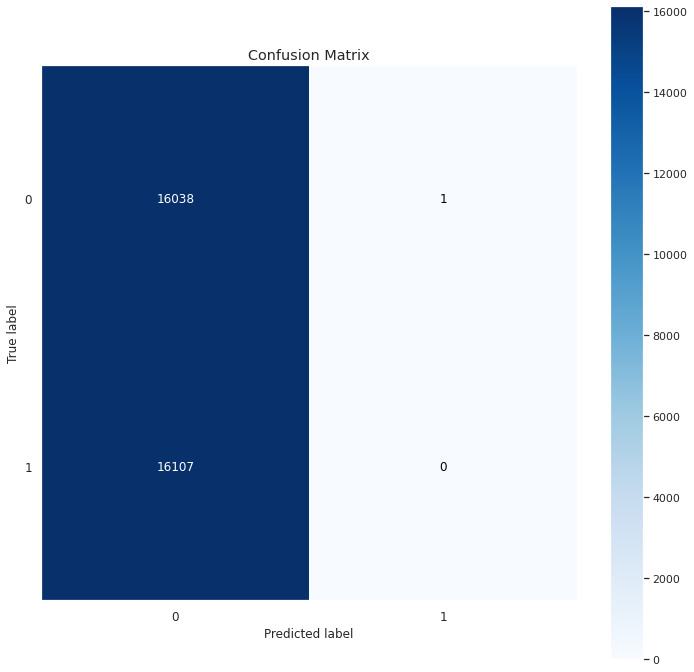

In [32]:
#acurácia
accuracy_knn = knn_model.score(x_train, y_train)
print(f'Acurária = {accuracy_knn}')

#matriz de confusão
mt.plot_confusion_matrix( y_val, yhat_knn, normalize=False, figsize=(12,12));

#Kappa
kappa_knn = m.cohen_kappa_score (y_val, yhat_knn)
print(f'Kappa Score = {kappa_knn}')

#classification report
print(m.classification_report(y_val, yhat_knn))

### 8.2 Logistic Regression

In [33]:
#modelo
lr_model = lm.LogisticRegression(random_state=42, max_iter=100000)

#treinando o modelo
lr_model.fit(x_train, y_train)

#predições do modelo
yhat_proba_lr = knn_model.predict_proba(x_val)
yhat_lr = knn_model.predict(x_val)

### 8.2.1 Logistic Regression Metricas

Acurária = 0.65142323845077
Kappa Score = -6.22161470373861e-05
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     16039
           1       0.00      0.00      0.00     16107

    accuracy                           0.50     32146
   macro avg       0.25      0.50      0.33     32146
weighted avg       0.25      0.50      0.33     32146



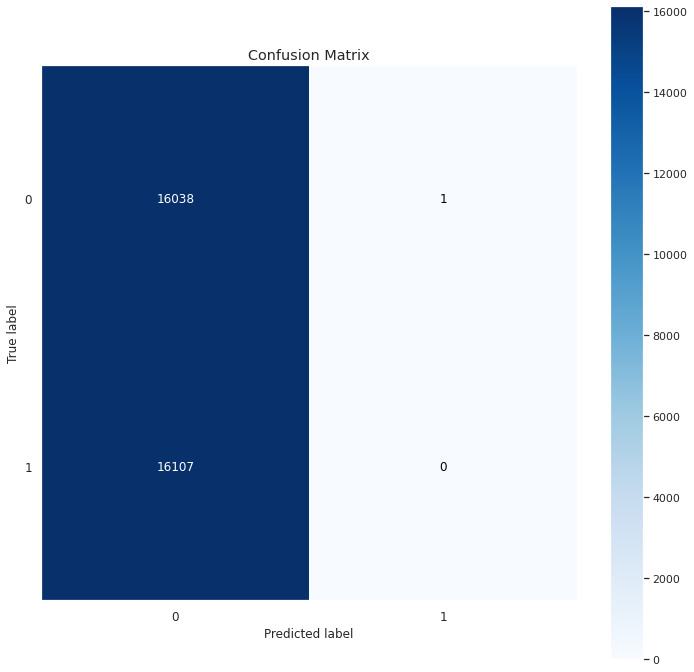

In [34]:
#acurácia
accuracy_lr = lr_model.score(x_train, y_train)
print(f'Acurária = {accuracy_lr}')

#Matriz de Confusão
mt.plot_confusion_matrix( y_val, yhat_lr, normalize=False, figsize=(12,12));

#Kappa Metrics
kappa_lr = m.cohen_kappa_score (y_val, yhat_lr)
print(f'Kappa Score = {kappa_lr}')

#classification report
print(m.classification_report(y_val, yhat_lr))

### 8.3 XGBoost 

In [35]:
#modelo
xgb = XGBClassifier(objective='binary:logistic', verbosity=0)

#treinando o modelo
xgb.fit(x_train, y_train)

#presições do modelo
yhat_proba_xgb = xgb.predict_proba(x_val)
yhat_xgb = xgb.predict(x_val)


### 8.3.1 XGBoost Metricas

Acurária = 0.7666277803701975
Kappa Score = 0.47344753499983605
              precision    recall  f1-score   support

           0       0.70      0.81      0.76     16039
           1       0.78      0.66      0.72     16107

    accuracy                           0.74     32146
   macro avg       0.74      0.74      0.74     32146
weighted avg       0.74      0.74      0.74     32146



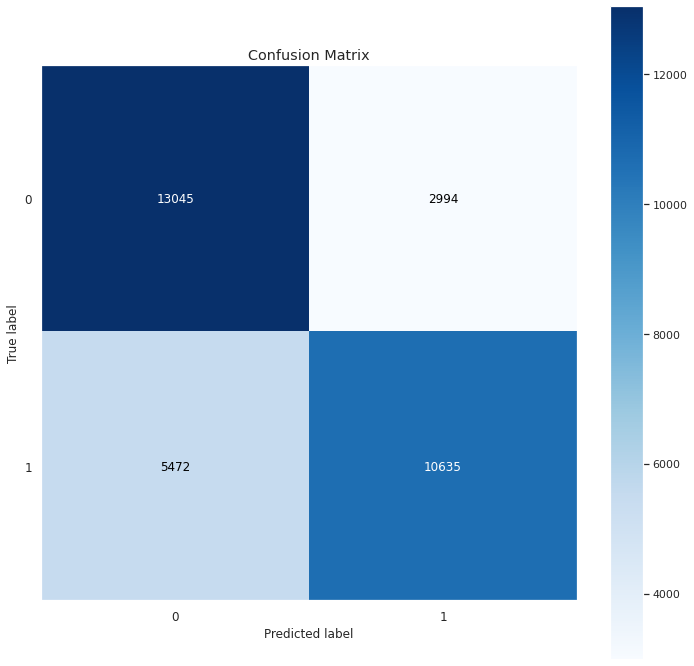

In [36]:
#acurácia
accuracy_xgb = xgb.score(x_train, y_train)
print(f'Acurária = {accuracy_xgb}')

#Matriz de Confusão
mt.plot_confusion_matrix( y_val, yhat_xgb, normalize=False, figsize=(12,12));

#Kappa
kappa_xgb = m.cohen_kappa_score (y_val, yhat_xgb)
print(f'Kappa Score = {kappa_xgb}')

#classification report
print(m.classification_report(y_val, yhat_xgb))


# 9.0 Performance dos Modelos

In [37]:
dict_resusts = {'KNN': [0.61, 0.25, 0.5, 0.33, -6.22], 'Logistic Regression': [0.65, 0.25, 0.5, 0.33, -6.22], 'XGBoost':[ 0.76, 0.74,0.74,0.74, 0.47]}
df_results = pd.DataFrame.from_dict(dict_resusts).T.reset_index()
df_results.columns = (['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Kappa Score'])
df_results

,Model,Accuracy,Precision,Recall,F1-Score,Kappa Score
0,KNN,0.61,0.25,0.50,0.33,-6.22
1,Logistic Regression,0.65,0.25,0.50,0.33,-6.22
2,XGBoost,0.76,0.74,0.74,0.74,0.47


# 10.0 Teste - Predições

In [38]:
#importando dados de teste
teste = pd.read_csv('teste.csv')

#reescalando dados de teste
#util_linhas_inseguras
teste_modif  = teste.copy()

teste_modif['util_linhas_inseguras'] = rs.fit_transform(teste[['util_linhas_inseguras']].values)

#razao_debito
teste_modif['razao_debito'] = rs.fit_transform(teste[['razao_debito']].values)

#salario_mensal
teste_modif['salario_mensal'] = rs.fit_transform(teste[['salario_mensal']].values)


teste_modif = teste[['util_linhas_inseguras', 
                 'salario_mensal',
                 'razao_debito', 
                 'idade', 
                 'numero_linhas_crdto_aberto',
                 'vezes_passou_de_30_59_dias']]

#aplicando modelo nos dados de teste
model = xgb
pred_teste = model.predict(teste_modif)
teste['inadimplente'] = pred_teste

#tranformando dataset em csv
teste.to_csv('teste_resultados.csv')

#resutados
teste.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,1
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,0


# 11.0 Considerações Finais

-O modelo com melhores resultados foi o XGBoost, portanto foi o modelo escolhido para aplicar nos dados de teste.

-Caso a instituição financeira esteja interessada em ofertar crédito para mais clientes,  correndo o risco de oferecer crédito também para clientes inadimplentes, a precisão do modelo é uma boa métrica para entender o impacto do modelo.

-Caso a instituição financeira esteja interessada em não oferecer crédito para clientes com perfil de inadimplência, correndo o risco de deixar de oferecer crédito para clientes bons pagadores, o recall é uma boa métrica para entender o impacto do modelo.